In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

def plot_protein_ratio(df, group1_indices, group2_indices, title, organism_colors):
    """
    Plots a ratio plot of proteins with log2 intensity vs. log2 fold change between two groups,
    and a density plot of log2 fold change for each organism with log2 fold change on the y-axis and density on the x-axis.

    Parameters:
    - df: pandas DataFrame containing the data.
    - group1_indices: list of column indices for group 1.
    - group2_indices: list of column indices for group 2.
    - title: string, title of the plot.
    - organism_colors: dict, mapping of organism names to colors.
    """
    # Define the columns corresponding to the two groups
    group1_columns = df.columns[group1_indices]
    group2_columns = df.columns[group2_indices]

    # Count the number of non-NaN values in each group
    df['non_nan_count_group1'] = df[group1_columns].notna().sum(axis=1)
    df['non_nan_count_group2'] = df[group2_columns].notna().sum(axis=1)

    # Filter the data to include only rows with at least 2 non-NaN values in each group
    filtered_df = df[(df['non_nan_count_group1'] >= 2) & (df['non_nan_count_group2'] >= 2)].copy()

    # Calculate the average MS2 quantity for each group in the filtered data
    filtered_df['avg_group1'] = filtered_df.loc[:, group1_columns].mean(axis=1)
    filtered_df['avg_group2'] = filtered_df.loc[:, group2_columns].mean(axis=1)

    # Calculate log2 intensity for each protein
    filtered_df['log2_intensity'] = np.log2((filtered_df['avg_group1'] + filtered_df['avg_group2']) / 2)

    # Calculate log2 fold change between the two groups
    filtered_df['log2_fold_change'] = np.log2(filtered_df['avg_group2'] / filtered_df['avg_group1'])

    # Map colors to the organisms in the filtered data
    filtered_df['color'] = filtered_df['PG.Organisms'].map(organism_colors)

    # Plotting
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6), gridspec_kw={'width_ratios': [3, 1]})

    # Scatter plot
    scatter = ax1.scatter(filtered_df['log2_intensity'], filtered_df['log2_fold_change'], 
                          c=filtered_df['color'], alpha=0.3)
    ax1.axhline(0, color='gray', linestyle='--')
    ax1.set_xlabel('log2 Intensity', size=20)
    ax1.set_ylabel('log2 Fold Change', size=20)
    ax1.tick_params(axis='x', labelsize=16)
    ax1.tick_params(axis='y', labelsize=16)

    # Set y-axis ticks with a gap of 1
    y_min, y_max = filtered_df['log2_fold_change'].min(), filtered_df['log2_fold_change'].max()
    ax1.set_yticks(np.arange(np.floor(y_min), np.ceil(y_max) + 1, 1))
    ax1.set_title(title, size=28,pad=16)
    ax1.grid(True)

    # Create a legend
    for organism, color in organism_colors.items():
        ax1.scatter([], [], c=color, label=organism)
    #ax1.legend(fontsize=6)
    
    # Density plots
    for organism, color in organism_colors.items():
        org_data = filtered_df[filtered_df['PG.Organisms'] == organism]['log2_fold_change']
        total_points = len(org_data)

        
        # Compute KDE
        kde = gaussian_kde(org_data, bw_method=0.5)
        x = np.linspace(org_data.min(), org_data.max(), 1000)
        y = kde(x)
        
        # Plot KDE
        ax2.plot(y, x, color=color, label=organism)
        
        # Find the maximum density value
        max_idx = np.argmax(y)
        max_density = y[max_idx]
        max_log2FC = x[max_idx]
        count_within_threshold = ((org_data >= (max_log2FC - 0.138)) & (org_data <= (max_log2FC + 0.138))).sum()

        # Annotate the maximum density value
        ax2.annotate(f'{max_log2FC:.2f} Count: {count_within_threshold}/{total_points}', xy=(2.8, max_log2FC-0.138), 
                     xytext=(2, max_log2FC),
                     textcoords='offset points',
                     fontsize=12, color=color)

        # Draw horizontal threshold lines
        ax2.axhline(y=max_log2FC - 0.138, color=color, linestyle='--', linewidth=1, alpha=0.7)
        ax2.axhline(y=max_log2FC + 0.138, color=color, linestyle='--', linewidth=1, alpha=0.7)
        #ax2.text(3, max_log2FC - 0.138, f'Count: {count_within_threshold}/{total_points}', 
        #         color=color, fontsize=10, verticalalignment='bottom', horizontalalignment='center')

    # Set y-axis limits to match the main plot
    ax2.set_ylim(ax1.get_ylim())
    ax2.set_xlim(-0.1,2.8)    
    ax2.set_xticks([0,1,2])
    ax2.tick_params(axis='x', labelsize=16)
    ax2.tick_params(axis='y', labelsize=16)

    ax2.set_xlabel('Density', size=20)
    ax2.set_title('')

    plt.tight_layout()
    plt.savefig(title+".png", dpi=300)
    plt.show()





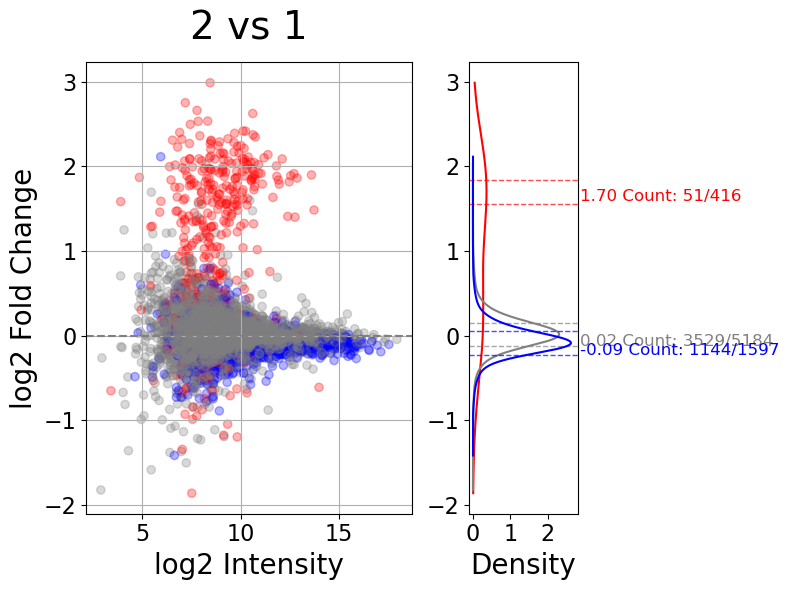

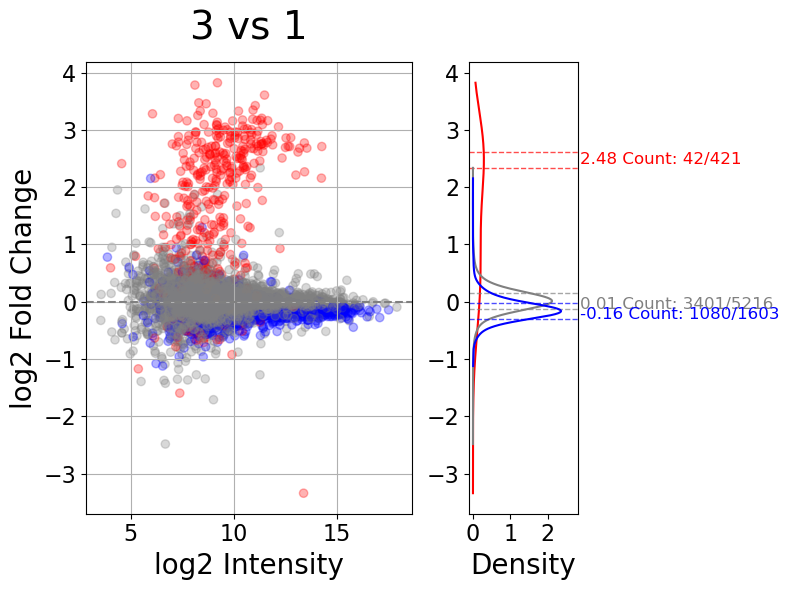

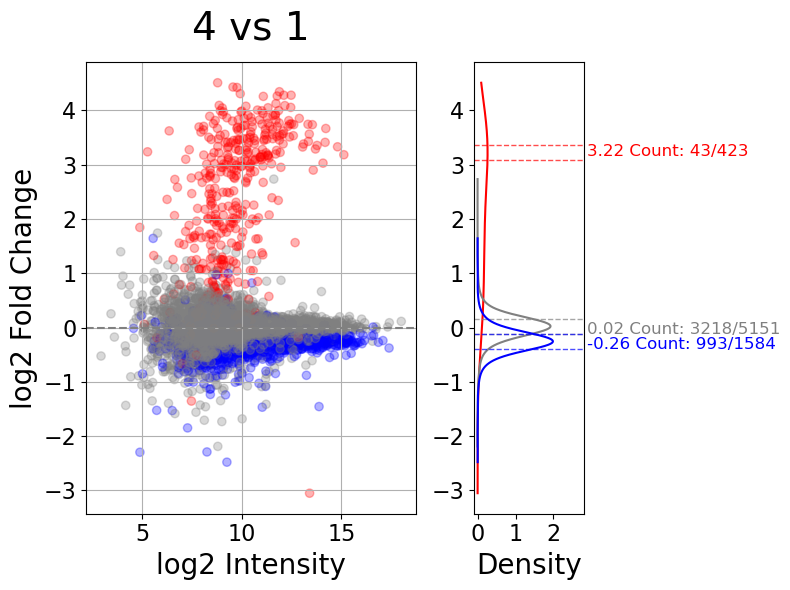

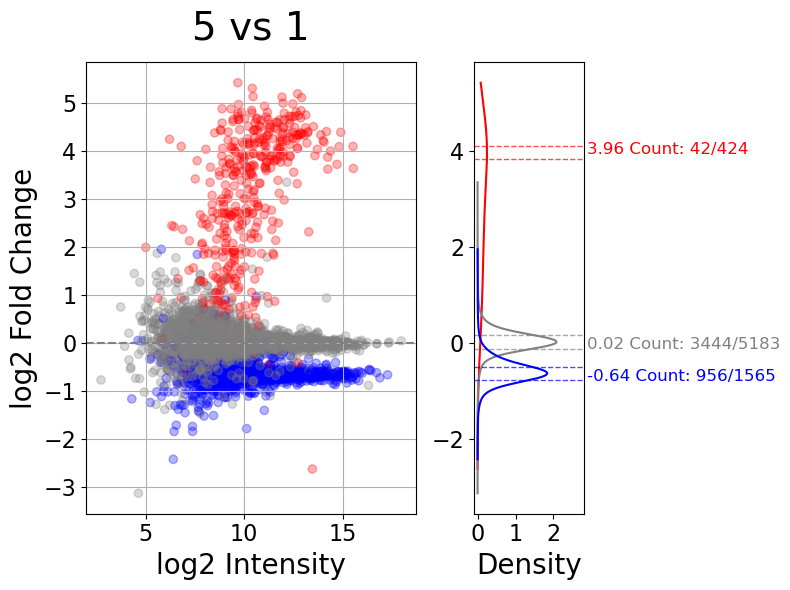

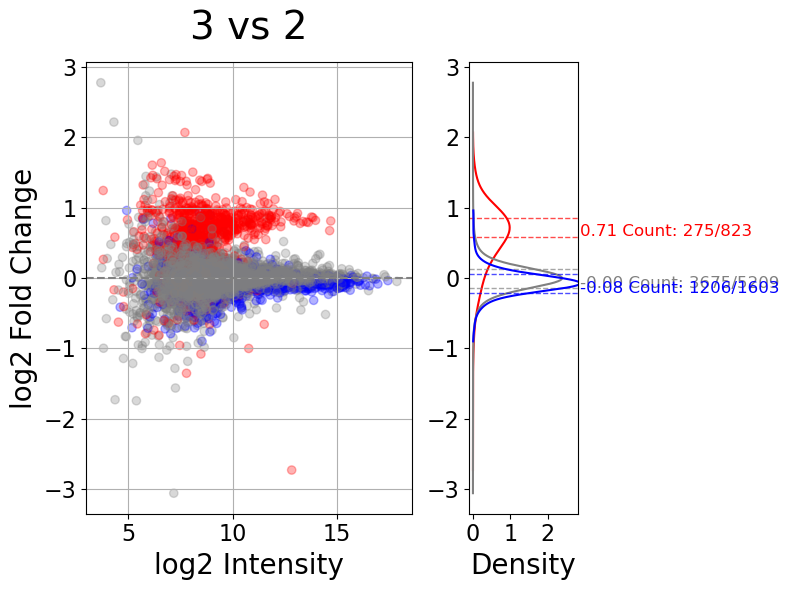

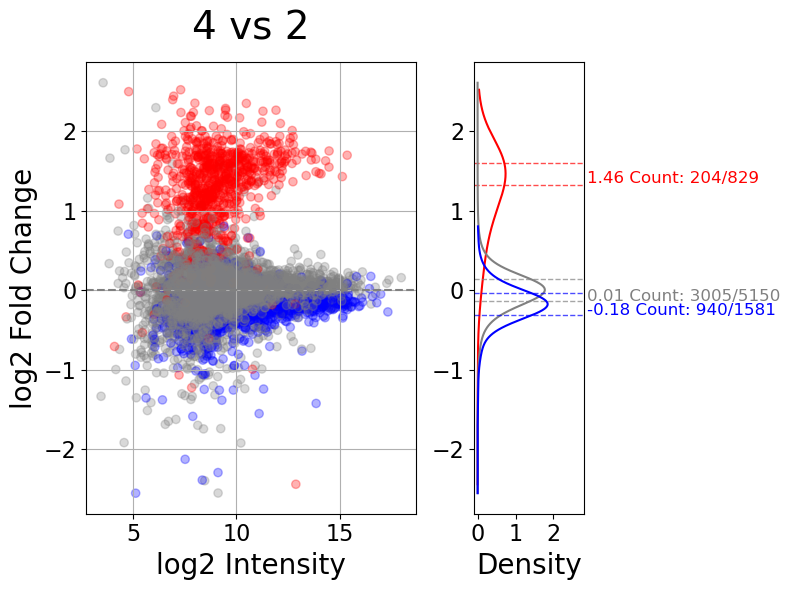

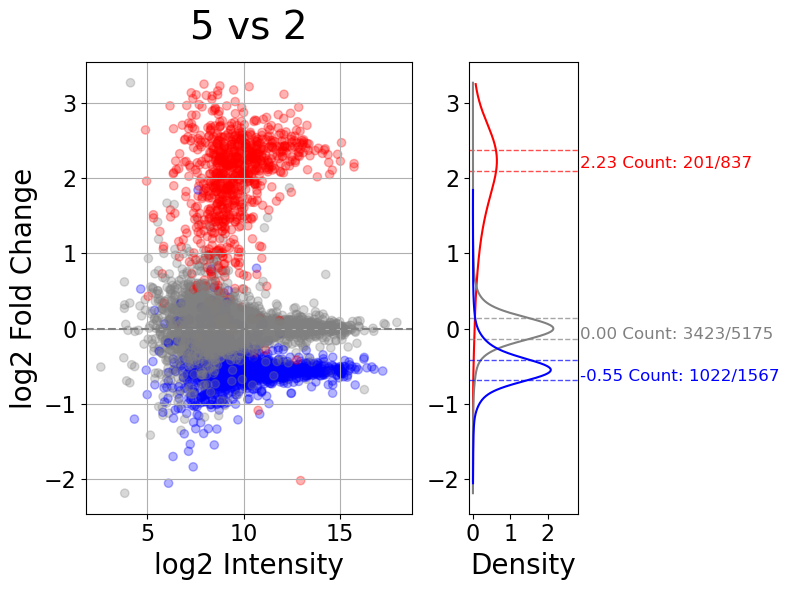

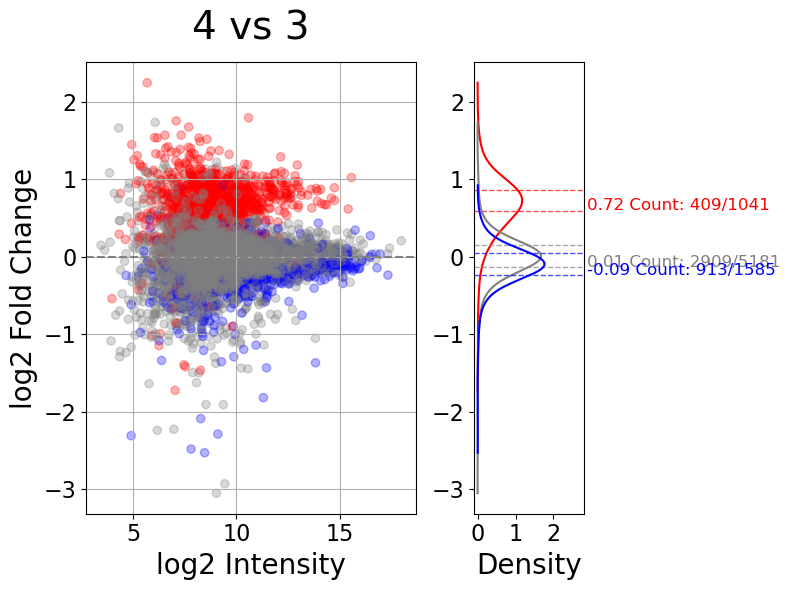

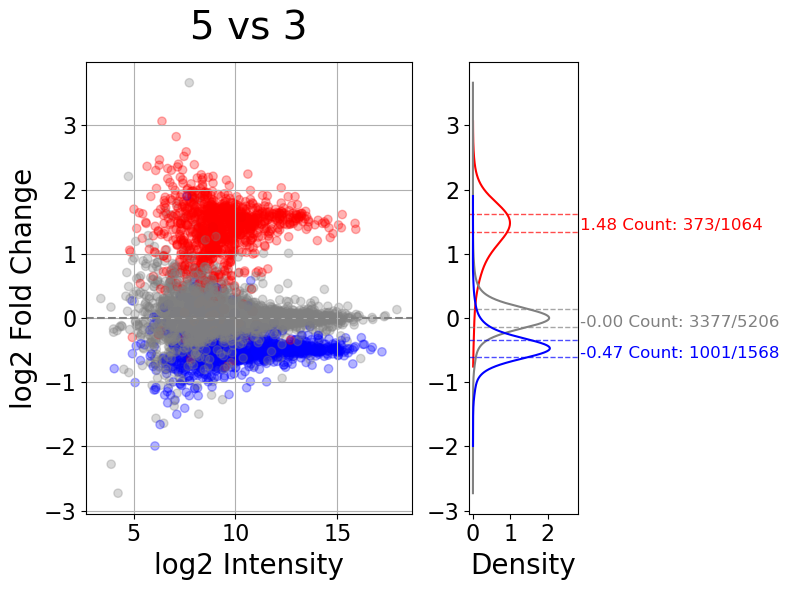

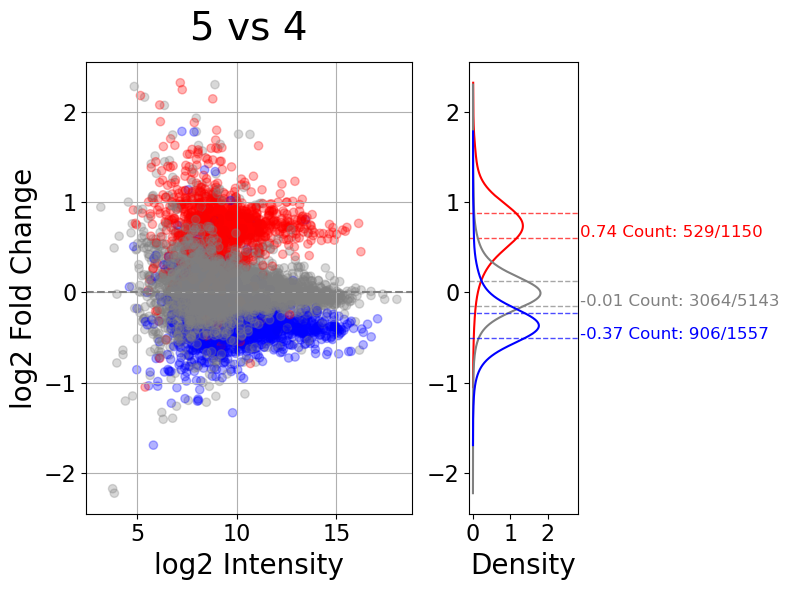

In [30]:
# Example usage:
# Load the data
df = pd.read_csv('20240730_165304_BCM_JW_300SPD_200ng_Report.csv')

# Define the color mapping for organisms
organism_colors = {
    'Saccharomyces cerevisiae (strain ATCC 204508 / S288c)': 'red',
    'Homo sapiens': 'grey',
    'Escherichia coli (strain K12)': 'blue',
}

# Call the function with appropriate parameters
plot_protein_ratio(df=df, group1_indices=[5,6,7], group2_indices=[8, 9, 10], title='2 vs 1', organism_colors=organism_colors)
plot_protein_ratio(df=df, group1_indices=[5, 6, 7], group2_indices=[11,12,13], title='3 vs 1', organism_colors=organism_colors)
plot_protein_ratio(df=df, group1_indices=[5, 6, 7], group2_indices=[14,15,16], title='4 vs 1', organism_colors=organism_colors)
plot_protein_ratio(df=df, group1_indices=[5, 6, 7], group2_indices=[17,18,19], title='5 vs 1', organism_colors=organism_colors)
plot_protein_ratio(df=df, group1_indices=[8, 9, 10], group2_indices=[11,12,13], title='3 vs 2', organism_colors=organism_colors)
plot_protein_ratio(df=df, group1_indices=[8, 9, 10], group2_indices=[14,15,16], title='4 vs 2', organism_colors=organism_colors)
plot_protein_ratio(df=df, group1_indices=[8, 9, 10], group2_indices=[17,18,19], title='5 vs 2', organism_colors=organism_colors)
plot_protein_ratio(df=df, group1_indices=[11,12,13], group2_indices=[14,15,16], title='4 vs 3', organism_colors=organism_colors)
plot_protein_ratio(df=df, group1_indices=[11,12,13], group2_indices=[17,18,19], title='5 vs 3', organism_colors=organism_colors)
plot_protein_ratio(df=df, group1_indices=[14,15,16], group2_indices=[17,18,19], title='5 vs 4', organism_colors=organism_colors)